In [1]:
import numpy as np
import math
import sympy as sp
import matplotlib.pyplot as plt

## Функция Бесселя

Задаётся рядом вида:

$$J_0(x) = \sum\limits_{k=0}^{\infty}\frac{(-1)^k}{(k!)^2}\left(\frac{x}{2}\right)^{2k}$$

Считаем, что погрешность порядка первого отброшенного члена. 

Производную ищем по формуле 2 порядка:

$$ f'(x) \simeq \frac{f(x+h) - f(x-h)}{2h} $$
$$ \left|f'(x) - \frac{f(x+h) - f(x-h)}{2h}\right| \le \frac{M_2h^2}{6} \le \frac{h^2}{6}$$

Оптимальный шаг дифференцирования:

$$ h_{opt} = 2\sqrt{\frac{\Delta f}{M_2}} \ge  2\sqrt{\Delta f}$$

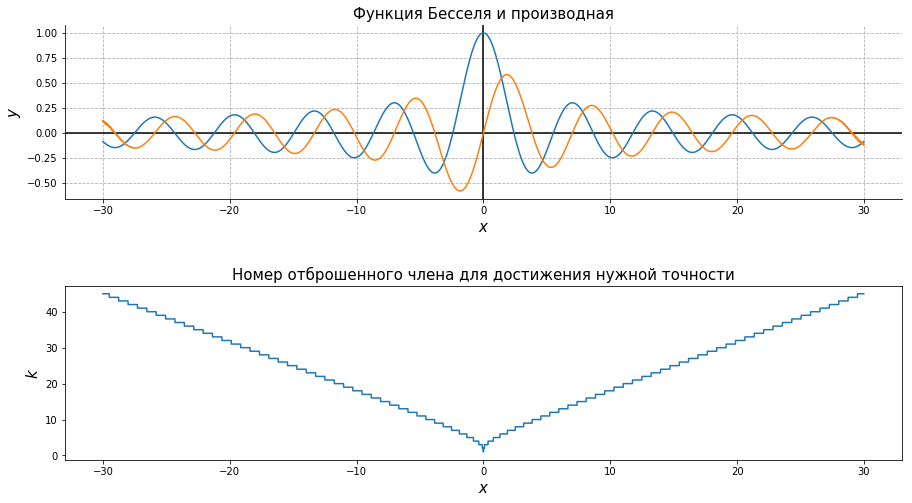

In [2]:
x_min, x_max, step = -30.0, 30.0, 0.01
err = 10**(-6)
h = 2*math.sqrt(err)
k_max = 1000

def bessel(x):
    S = 0.0
    s_k = 1.0
    k = 1
    while k < k_max:
        S += s_k
        s_k *= (-1)*(x/(2*k))**2
        if math.fabs(s_k) < err:
            break
        k += 1
    
    return S, k

def dbessel(x, dx):
    return (bessel(x-dx)[0] - bessel(x+dx)[0])/(2*dx) 

from functools import partial

dbessel = partial(dbessel, dx=h)

bessel = np.vectorize(bessel, otypes=[np.float, np.float])
dbessel = np.vectorize(dbessel, otypes=[np.float])

xs = np.arange(x_min, x_max, step)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Функция Бесселя и производная', fontsize=15)
axes[0].set_xlabel(r'$x$', fontsize=15)
axes[0].set_ylabel(r'$y$', fontsize=15)

axes[0].grid(True)

axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[0].axhline(0, color='k')
axes[0].axvline(0, color='k')

gridlines = axes[0].get_xgridlines() + axes[0].get_ygridlines()

for line in gridlines:
    line.set_linestyle('--')

ys, ks = bessel(xs)
axes[0].plot(xs, ys)
axes[0].plot(xs, dbessel(xs))

axes[1].set_title('Номер отброшенного члена для достижения нужной точности', fontsize=15)
axes[1].set_xlabel(r'$x$', fontsize=15)
axes[1].set_ylabel(r'$k$', fontsize=15)
axes[1].plot(xs, ks)

fig.subplots_adjust(hspace=0.5)
plt.show()

## Трёхдиагональная система

$$\begin{cases}
u_0 & & & = 0,\\
&-u_{n-1} + (2+h^2)u_n - u_{n+1} & &= 2h^2sin(nh), \quad n = \overline{1, N-1},\\
& & u_N &= 0.
\end{cases}$$

Где $N = 20, h = \frac{\pi}{N}$.

$$ P_{k+1} = - \frac{c_k}{a_kP_k + b_k}, \quad Q_{k+1} = \frac{f_k - a_kQ_k}{a_kP_k+b_k}$$

$$ a = c = (0, -1, \dotsc, -1, 0)$$

$$ b = (1, (2+h^2), \dotsc, (2+h^2), 1)$$

$$ f = (0, 2h^2\sin(h),\dotsc, 2h^2\sin((N-1)h), 0)$$

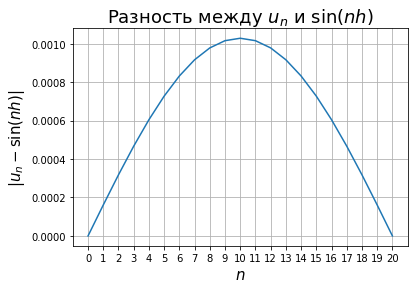

x = [ 0.          0.15659533  0.30933475  0.45445734  0.58838967  0.7078339
  0.8098489   0.89192274  0.95203448  0.98870398  1.00102829  0.98870398
  0.95203448  0.89192274  0.8098489   0.7078339   0.58838967  0.45445734
  0.30933475  0.15659533  0.        ]
err = 0.00102829490343


In [61]:
N = 20
h = math.pi/N

a = np.full(N+1, -1)
a[0] = a[N] = 0
c = a
b = np.full(N+1, 2+h**2)
b[0] = b[N] = 1
f = np.arange(N+1)
f[N] = 0
f = 2*h**2*np.sin(f*h)

P = np.zeros(N+1)
Q = np.zeros(N+1)

P[0] = -c[0]/b[0]
Q[0] = f[0]/b[0]

for k in range(N):
    P[k+1] = - c[k+1]/(a[k+1]*P[k] + b[k+1])
    Q[k+1] = (f[k+1] - a[k+1]*Q[k])/(a[k+1]*P[k] + b[k+1])
    
x = np.zeros(N+1)
t = np.arange(N+1)
t = np.sin(t*h)
x[N] = Q[N]
for k in reversed(range(N)):
    x[k] = P[k] * x[k+1] + Q[k]

xs = np.arange(N+1)

fig, axe = plt.subplots()
axe.set_title(r'Разность между $u_n$ и $\sin (nh)$', fontsize=15)
axe.set_xlabel(r'$n$', fontsize=15)
axe.set_ylabel(r'$|u_n - \sin (nh)|$', fontsize=15)
axe.xaxis.set_major_locator(plt.IndexLocator(1, 0))
axe.plot(xs, np.absolute(x - t))
axe.grid(True)
plt.show()

print('x =', x)
print('err =', np.max(np.absolute(x - t)))

## Метод Зейделя

Решаем линейную систему:

$$ \left(\mathbf{I} - \lambda \mathbf{K}\right)\mathbf{u} = \mathbf{f}$$
$$ \mathbf{I}_{nm} = \delta_{nm}$$
$$ \mathbf{K}_{nm} = h^2|n-m|$$
$$ \mathbf{f}_n = (1+2\lambda)\cos^2\frac{x_n}{2} - \lambda \frac{x_n^2 + \pi^2}{2}, \quad x_n = -\pi + (n - \frac{1}{2})h, \quad h = \frac{2\pi}{N}$$

$$ \lambda = 0.01, \quad N = 100$$

Величина ошибки: 3.05430193301e-07
Число итераций: 6
Максимальное отличие от косинуса: 6.82237941585e-06
При x: -0.0314159265359


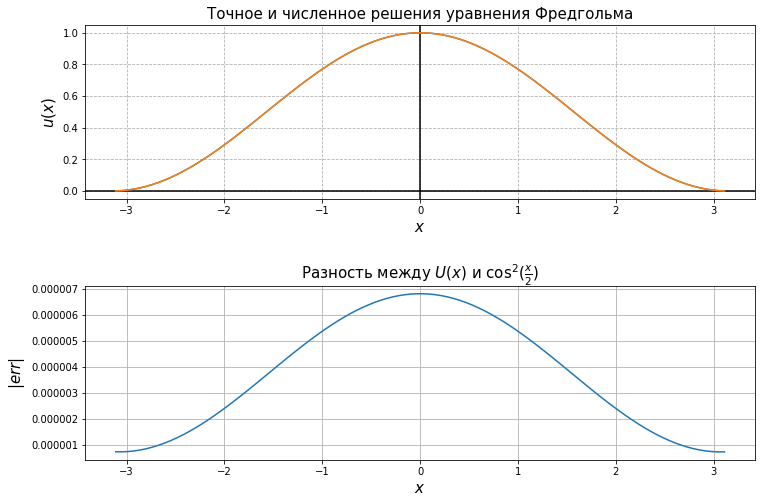

In [85]:
N = 100
lambd = 0.01
k_max = 1000
eps = 10**(-6)

h = 2*math.pi/N
x = np.fromfunction(lambda n: -math.pi +(n+1/2)*h, (N,), dtype=np.float)
I = np.eye(N)
K = np.fromfunction(lambda m, n, h=h: h**2*np.fabs(m - n), (N, N), dtype=np.float)
A = I - lambd*K
f = (1+2*lambd)*(np.cos(x/2))**2 - lambd /2 * (np.square(x) + math.pi**2)

u_new = np.zeros(N)

for it in range(k_max):
    u_old = np.copy(u_new)
    for i in range(N):
        L = np.dot(A[i, :i], u_new[:i])
        U = np.dot(A[i, i+1:], u_new[i+1:])
        u_new[i] = (f[i] - L - U) / A[i, i]
    if np.linalg.norm(u_old - u_new) < eps:
        break;

err = np.abs(np.cos(x/2)**2 - u_new)
print('Величина ошибки:', np.linalg.norm(u_old - u_new))
print('Число итераций:', it + 1)
print('Максимальное отличие от косинуса:', np.max(err))
print('При x:', x[np.argmax(err)])
        
fig, (axe, axe_err) = plt.subplots(2, 1, figsize=(12, 8))
axe.set_title(r'Точное и численное решения уравнения Фредгольма', fontsize=15)
axe.set_xlabel(r'$x$', fontsize=15)
axe.set_ylabel(r'$u(x)$', fontsize=15)
axe.grid(True)

axe.axhline(0, color='k')
axe.axvline(0, color='k')

gridlines = axe.get_xgridlines() + axe.get_ygridlines()

for line in gridlines:
    line.set_linestyle('--')
    
axe.plot(x, np.cos(x/2)**2)
axe.plot(x, u_new)

axe_err.set_title(r'Разность между $U(x)$ и $\cos^2 (\frac{x}{2})$', fontsize=15)
axe_err.set_xlabel(r'$x$', fontsize=15)
axe_err.set_ylabel(r'$|err|$', fontsize=15)
axe_err.plot(x, err)
axe_err.grid(True)
fig.subplots_adjust(hspace=0.5)

plt.show()

## Нелинейные уравнения 



In [92]:
p_cr = 3.77*10**6
V_cr = 0.1095
R = 8314
eps = 10**(-14)
T = 300
p = 10**5

def bin_search(f, x_min, x_max, eps):
    while x_max - x_min > eps:
        mid = (x_min + x_max)/2
        if f(mid) < 0:
            x_min = mid
        else:
            x_max = mid
    return (x_min, x_max)

def wander(V, p, T, R, p_cr, V_cr):
    return (p + 3*p_cr*V_cr**2/V**2)*(V - V_cr/3)-R*T

wander_V = lambda V, p=p, T=T, R=R, p_cr=p_cr, V_cr=V_cr: wander(V, p, T, R, p_cr, V_cr)
V = bin_search(wander_V, 0, 10*6, eps)
print(V[0])

24.924170756207943


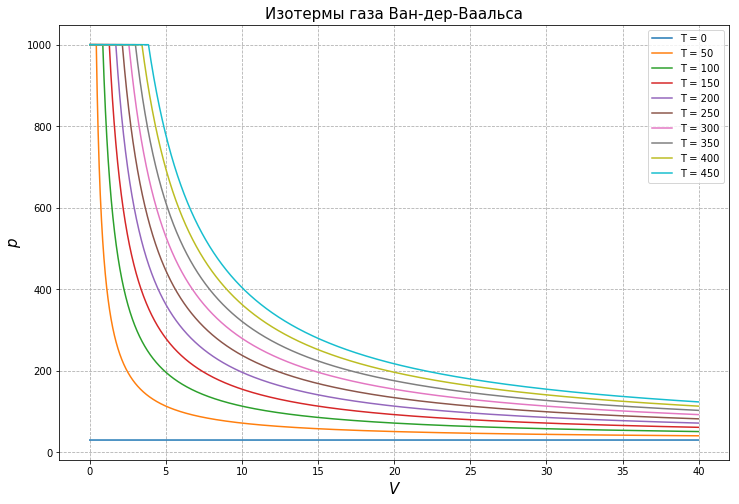

In [91]:
p_cr = 225*10**5
V_cr = 0.055
R = 8.31
eps = 10**(-8)

a = 5.464*10**(-6)
b = 30.5
import copy

def bin_search(f, x_min_in, x_max_in, eps):
    x_max = copy.copy(x_max_in)
    x_min = copy.copy(x_min_in)
    while x_max - x_min > eps:
        mid = (x_min + x_max)/2
        if f(mid) < 0:
            x_min = mid
        else:
            x_max = mid
    return (x_min + x_max) /2

def wander(V, p, T, R, p_cr, V_cr):
    return (p + 3*p_cr*V_cr**2/V**2)*(V - V_cr/3)-R*T

def wander_ab(V, p, T, R, a, b):
    return (p + a/V**2)*(V - b)-R*T

P_min, P_max = -10**2, 10**3
V = np.arange(0, 40, 0.01)
eps = 10**(-3)

fig, axe = plt.subplots(figsize=(12, 8))
axe.set_title(r'Изотермы газа Ван-дер-Ваальса', fontsize=15)
axe.set_xlabel(r'$V$', fontsize=15)
axe.set_ylabel(r'$p$', fontsize=15)
axe.grid(True)

gridlines = axe.get_xgridlines() + axe.get_ygridlines()

for line in gridlines:
    line.set_linestyle('--')
    
for T in range(0, 500, 50):
    wander_Vp = lambda V, p, T=T, R=R, p_cr=p_cr, V_cr=V_cr: wander(V, p, T, R, p_cr, V_cr)
    wander_Vp_ab = lambda V, p, T=T, R=R, a=a, b=b: wander_ab(V, p, T, R, a, b)
    wander_V  = lambda  V, P_min=P_min, P_max=P_max, eps=eps: bin_search(lambda p, V=V: wander_Vp(p, V), 
                                                                         P_min, 
                                                                         P_max, 
                                                                         eps)
    wander_V_ab  = lambda  V, P_min=P_min, P_max=P_max, eps=eps: bin_search(lambda p, V=V: wander_Vp_ab(p, V), 
                                                                         P_min, 
                                                                         P_max, 
                                                                         eps)
    wander_V = np.vectorize (wander_V, otypes=[np.float])
    wander_V_ab = np.vectorize (wander_V_ab, otypes=[np.float])
    axe.plot(V, wander_V_ab(V), label = 'T = {}'.format(T))

plt.legend()
plt.show()